## 1. Import Libraries

In [43]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt


import eda_helper_functions
import eda_utils
import helper

from sklearn.ensemble import IsolationForest

## 2. Read the Training Data

In [44]:
file_path = r"U:\nlp_project\flight-prices-prediction\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-27,Delhi,Cochin,05:00:00,19:15:00,2295,2.0,No Info,8026
1,Air India,2019-03-01,Banglore,New Delhi,08:50:00,23:55:00,2345,2.0,No Info,17135
2,Jet Airways,2019-06-15,Delhi,Cochin,12:15:00,04:25:00,970,2.0,No Info,14300
3,Indigo,2019-05-06,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info,5069
4,Air India,2019-03-21,Delhi,Cochin,23:00:00,19:15:00,1215,1.0,No Info,6745
...,...,...,...,...,...,...,...,...,...,...
8363,Indigo,2019-06-03,Banglore,Delhi,08:30:00,11:20:00,170,0.0,No Info,4823
8364,Jet Airways,2019-03-21,Banglore,New Delhi,07:00:00,21:20:00,860,1.0,In-flight meal not included,7832
8365,Indigo,2019-04-03,Delhi,Cochin,10:35:00,15:35:00,300,1.0,No Info,5073
8366,Indigo,2019-04-27,Delhi,Cochin,05:35:00,08:50:00,195,0.0,No Info,6015


### 2.1 Fixing Data Types

In [45]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [46]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})
# train
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [47]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-27,Delhi,Cochin,2025-01-24 05:00:00,2025-01-24 19:15:00,2295,2.0,No Info,8026
1,Air India,2019-03-01,Banglore,New Delhi,2025-01-24 08:50:00,2025-01-24 23:55:00,2345,2.0,No Info,17135
2,Jet Airways,2019-06-15,Delhi,Cochin,2025-01-24 12:15:00,2025-01-24 04:25:00,970,2.0,No Info,14300
3,Indigo,2019-05-06,Kolkata,Banglore,2025-01-24 08:10:00,2025-01-24 13:00:00,290,1.0,No Info,5069
4,Air India,2019-03-21,Delhi,Cochin,2025-01-24 23:00:00,2025-01-24 19:15:00,1215,1.0,No Info,6745
...,...,...,...,...,...,...,...,...,...,...
8363,Indigo,2019-06-03,Banglore,Delhi,2025-01-24 08:30:00,2025-01-24 11:20:00,170,0.0,No Info,4823
8364,Jet Airways,2019-03-21,Banglore,New Delhi,2025-01-24 07:00:00,2025-01-24 21:20:00,860,1.0,In-flight meal not included,7832
8365,Indigo,2019-04-03,Delhi,Cochin,2025-01-24 10:35:00,2025-01-24 15:35:00,300,1.0,No Info,5073
8366,Indigo,2019-04-27,Delhi,Cochin,2025-01-24 05:35:00,2025-01-24 08:50:00,195,0.0,No Info,6015


## 3. High-level Summary of Data

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8368 entries, 0 to 8367
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          8368 non-null   object        
 1   date_of_journey  8368 non-null   datetime64[ns]
 2   source           8368 non-null   object        
 3   destination      8368 non-null   object        
 4   dep_time         8368 non-null   datetime64[ns]
 5   arrival_time     8368 non-null   datetime64[ns]
 6   duration         8368 non-null   int64         
 7   total_stops      8368 non-null   float64       
 8   additional_info  8368 non-null   object        
 9   price            8368 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 653.9+ KB


In [49]:
train.describe(include="number")

,duration,total_stops,price
count,8368.000000,8368.000000,8368.000000
mean,634.401291,0.806883,9063.751673
std,502.780520,0.659752,4642.429420
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5277.000000
50%,510.000000,1.000000,8366.000000
75%,925.000000,1.000000,12373.000000
max,2860.000000,3.000000,79512.000000


In [50]:
train.describe(include="O")

,airline,source,destination,additional_info
count,8368,8368,8368,8368
unique,9,5,6,9
top,Jet Airways,Delhi,Cochin,No Info
freq,3000,3462,3462,6551


In [51]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,8368,8368,8368,8368.0,8368
unique,9,5,6,4.0,9
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,3000,3462,3462,4513.0,6551


## 4. High-level analysis of Missing Values

In [52]:
eda_utils.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [53]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [54]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-03-27,Delhi,Cochin,2025-01-24 05:00:00,2025-01-24 19:15:00,2295,2.0,No Info,8026,-1
1,Air India,2019-03-01,Banglore,New Delhi,2025-01-24 08:50:00,2025-01-24 23:55:00,2345,2.0,No Info,17135,-1
2,Jet Airways,2019-06-15,Delhi,Cochin,2025-01-24 12:15:00,2025-01-24 04:25:00,970,2.0,No Info,14300,-1
3,Indigo,2019-05-06,Kolkata,Banglore,2025-01-24 08:10:00,2025-01-24 13:00:00,290,1.0,No Info,5069,-1
4,Air India,2019-03-21,Delhi,Cochin,2025-01-24 23:00:00,2025-01-24 19:15:00,1215,1.0,No Info,6745,-1
...,...,...,...,...,...,...,...,...,...,...,...
8358,Spicejet,2019-06-06,Kolkata,Banglore,2025-01-24 22:20:00,2025-01-24 00:40:00,140,0.0,No check-in baggage included,3841,-1
8360,Air India,2019-03-18,Mumbai,Hyderabad,2025-01-24 21:05:00,2025-01-24 22:25:00,80,0.0,No Info,2050,-1
8365,Indigo,2019-04-03,Delhi,Cochin,2025-01-24 10:35:00,2025-01-24 15:35:00,300,1.0,No Info,5073,-1
8366,Indigo,2019-04-27,Delhi,Cochin,2025-01-24 05:35:00,2025-01-24 08:50:00,195,0.0,No Info,6015,-1


In [55]:
len(train)

8368

In [56]:
len((
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
))

3826

### Conclusion:
- There are Total 3826 rows contains outlier values.

## 6. Pair Plots

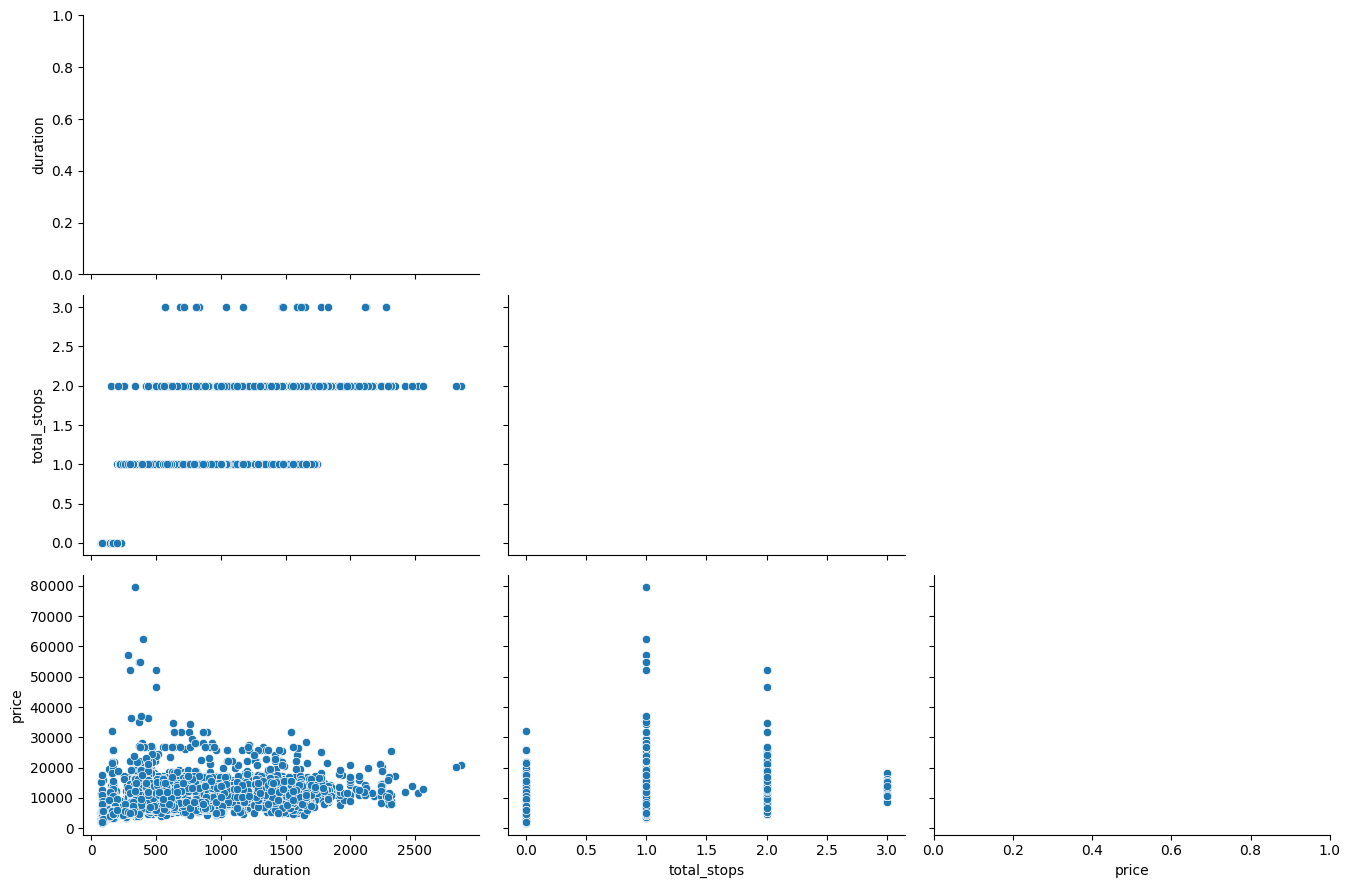

In [57]:
eda_utils.pair_plots(train)
# eda_helper_functions.pair_plots(train)

In [58]:
number_of_flights_with_0stops = len(train[train['total_stops']==0])
number_of_flights_with_1stops = len(train[train['total_stops']==1])
number_of_flights_with_2stops = len(train[train['total_stops']==2])
number_of_flights_with_3stops = len(train[train['total_stops']==3])

print("number of flights with 0 stops are: {}".format(number_of_flights_with_0stops))
print("number of flights with 1 stops are: {}".format(number_of_flights_with_1stops))
print("number of flights with 2 stops are: {}".format(number_of_flights_with_2stops))
print("number of flights with 3 stops are: {}".format(number_of_flights_with_3stops))

number of flights with 0 stops are: 2752
number of flights with 1 stops are: 4513
number of flights with 2 stops are: 1070
number of flights with 3 stops are: 33


### Conclusion:

#### 1. Duration Vs Price:
- Mojorty of flights costs bellow 20k, there are flights with price more then 20k, irrespctive of there duration.

#### 2. Total Stops Vs Price:
- Majorty of flights are with stop 1, and there price vary more compared to others. There are very less flights with total_stops==3, but it does't mean they are chepest.
There vary between approx 15k to 25k.

- There is no flight with total_stops==2 and price more then 60k.
- Price of flights with total_stops==0 is not more then 30k.

#### 3. Number of flights with there stops:
- number of flights with 0 stops are: 2752
- number of flights with 1 stops are: 4513
- number of flights with 2 stops are: 1070
- number of flights with 3 stops are: 33

## 7. Correlation Analysis

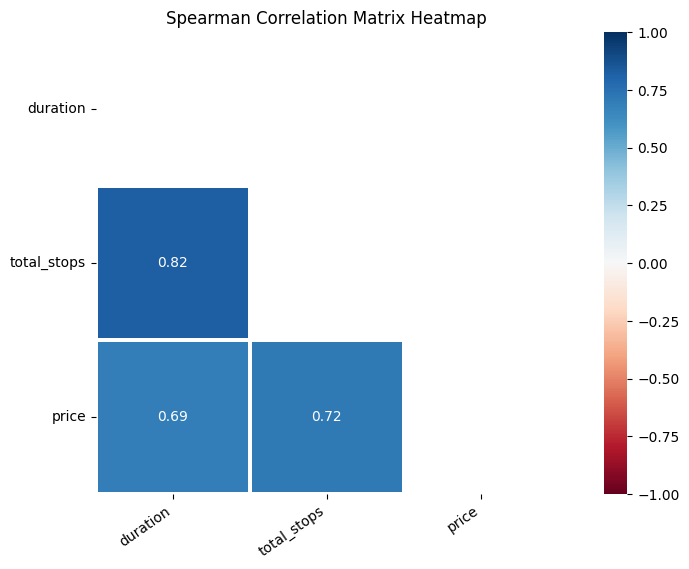

In [59]:
eda_helper_functions.correlation_heatmap(train)

### Conclusion:

#### 1. duration Vs total_stops:
- Relation between these 2 feature is most.
- Which means Number of stops highly impact duration of flights

#### 2. price Vs total_stops:
- correlation between these two is slights lower but shows total_stops do impact price of flight.

#### 3. price Vs duration:
- correlation between these two is least but shows, duration do impact price of flight.

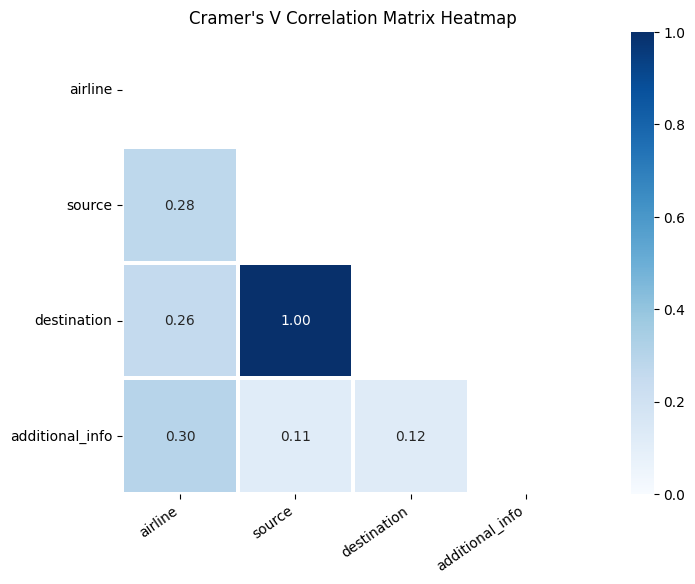

In [60]:
eda_helper_functions.cramersV_heatmap(train)

### Conclusion:
- source and destination and strong association, i.e, they are completly dependent on each other.
- additional_info has weak association with almost all variables, i.e, provides limited information.

# 8. Detailed Analysis

In [61]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [62]:
train.airline

0         Air India
1         Air India
2       Jet Airways
3            Indigo
4         Air India
           ...     
8363         Indigo
8364    Jet Airways
8365         Indigo
8366         Indigo
8367    Jet Airways
Name: airline, Length: 8368, dtype: object

In [63]:
eda_helper_functions.cat_summary(train, "airline")

0         Air India
1         Air India
2       Jet Airways
3            Indigo
4         Air India
           ...     
8363         Indigo
8364    Jet Airways
8365         Indigo
8366         Indigo
8367    Jet Airways
Name: airline, Length: 8368, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 8,368 / 8,368 rows


,
count,8368
unique,9
top,Jet Airways
freq,3000


,count,percentage
category,,
Jet Airways,3000,0.358509
Indigo,1611,0.192519
Air India,1358,0.162285
Multiple Carriers,941,0.112452
Spicejet,649,0.077557
Vistara,393,0.046965
Air Asia,258,0.030832
Goair,157,0.018762
Trujet,1,0.000120


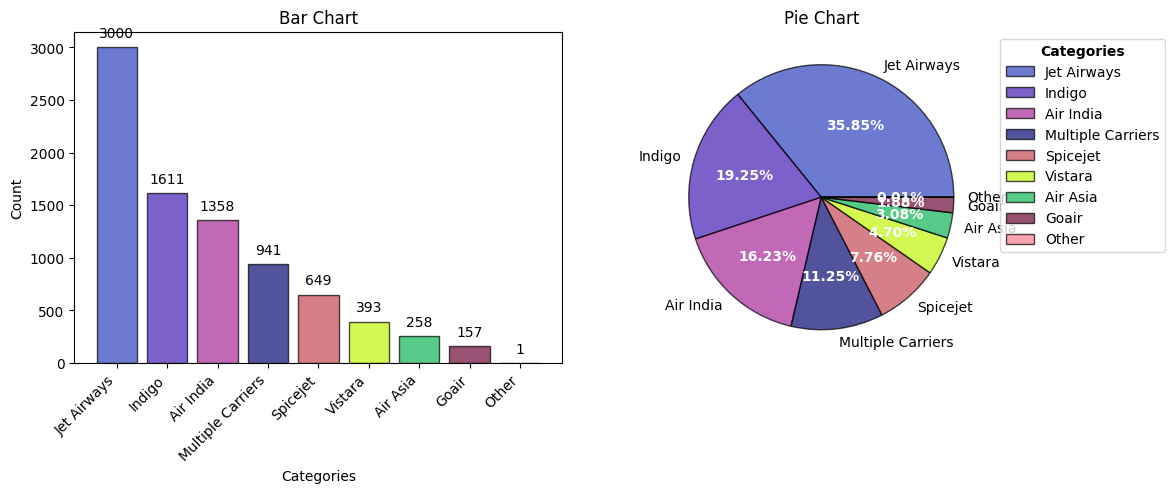

In [64]:
eda_helper_functions.cat_univar_plots(train, "airline",show_wordcloud=False, k=8)

### Conclusion:

- Most of flights are from Jet Airlines only. Arround 35.85% of flights are from Jet Airlines only.

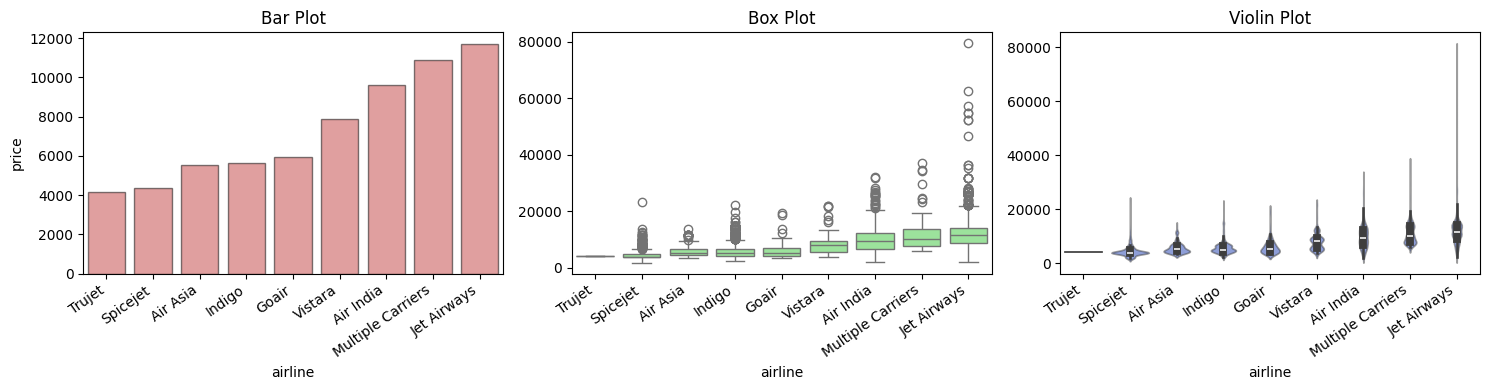

In [66]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

### Conclusion:

- Jet Airways flights are constlier then other flights.

In [67]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 558.9219989717759
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3813.3380770715958
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


In [42]:
# airline_grid = sns.FacetGrid(
# 	data=train,
# 	col="destination",
# 	col_wrap=3,
# 	height=4,
# 	aspect=1.2,
# 	sharey=True
# )

# airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

# for ax in airline_grid.axes[3:]:
# 	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [68]:
train.date_of_journey

0      2019-03-27
1      2019-03-01
2      2019-06-15
3      2019-05-06
4      2019-03-21
          ...    
8363   2019-06-03
8364   2019-03-21
8365   2019-04-03
8366   2019-04-27
8367   2019-05-21
Name: date_of_journey, Length: 8368, dtype: datetime64[ns]

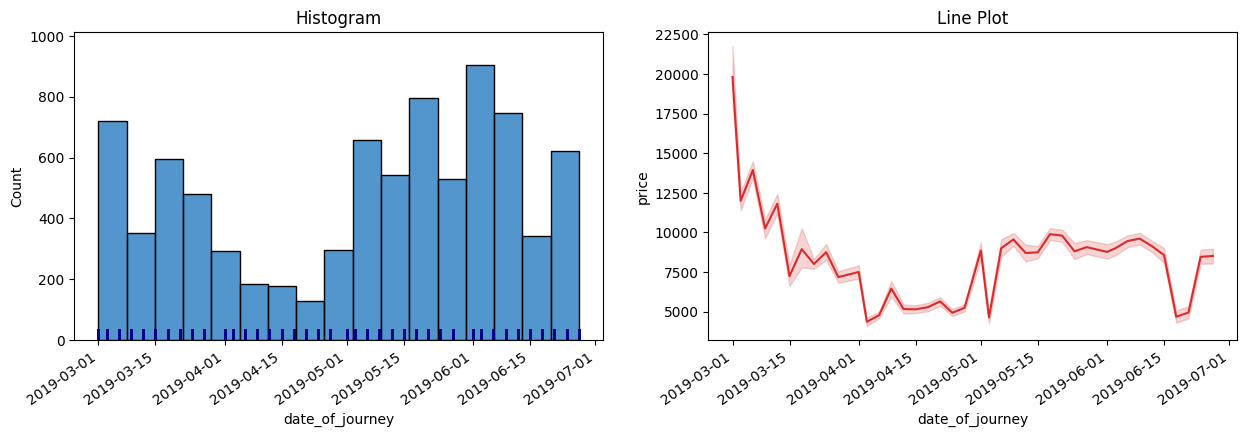

In [69]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

### Conclusion:

- From Historam we can conclude there are more flights in june-2019 due to some region.

- From line-plot we can conclude price are highest at start of march-2019. Then suddenly drops in april-2019 stabilizes during may-june and then rising again.

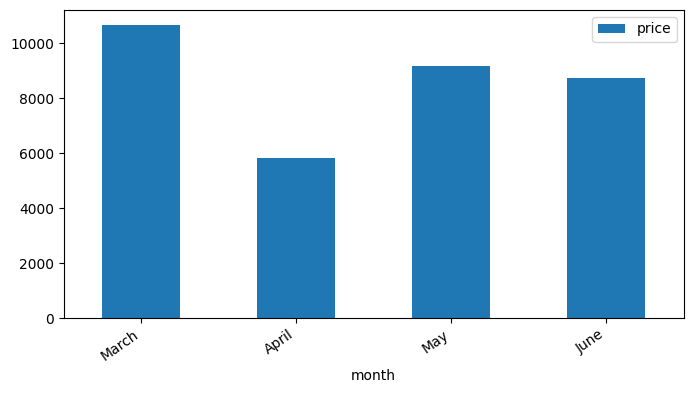

In [76]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		# edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

### Conclusion:

- From above bar-chart we can conclude in March price was high and in April price was least.

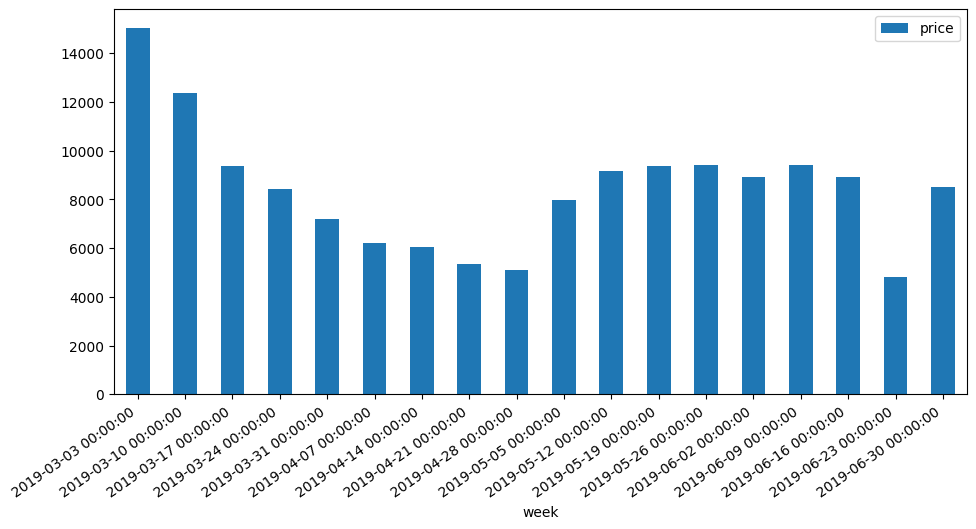

In [75]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(11, 5),
		# edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

### Conclusion:

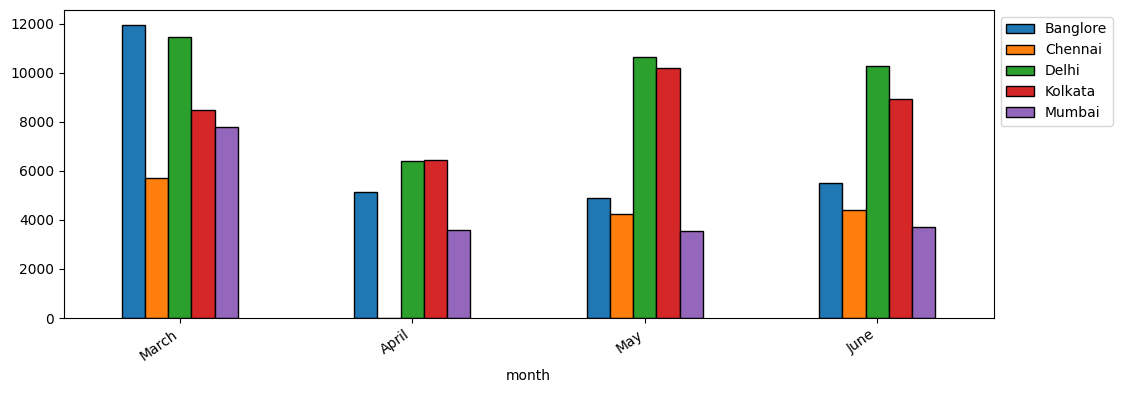

In [86]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### Conclusion:

- In month of march most of the flights are from bangalore and very less flights are from chennai.

- In april we have we less flights, among them most of them are from Kolkata and chennai

- In may most of the flights  are from Delhi only.

- In june most of the flights are from Chennai and least from mumbai.

### 8.3 dep_time

In [87]:
train.dep_time

0      2025-01-24 05:00:00
1      2025-01-24 08:50:00
2      2025-01-24 12:15:00
3      2025-01-24 08:10:00
4      2025-01-24 23:00:00
               ...        
8363   2025-01-24 08:30:00
8364   2025-01-24 07:00:00
8365   2025-01-24 10:35:00
8366   2025-01-24 05:35:00
8367   2025-01-24 09:40:00
Name: dep_time, Length: 8368, dtype: datetime64[ns]

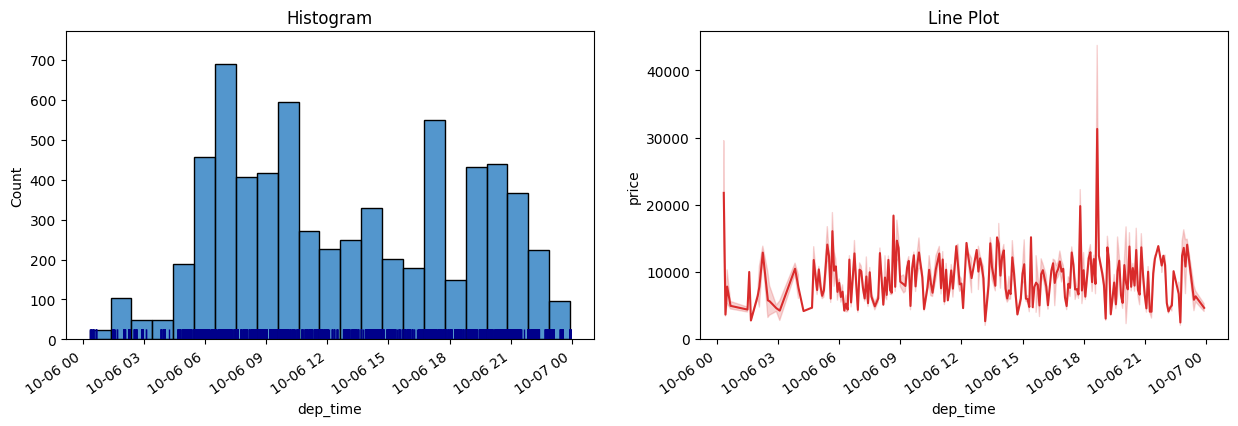

In [29]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

### Conclusion:

- majorty of flights are between 10-06 06 to 10-06 09. concluded from histogram.

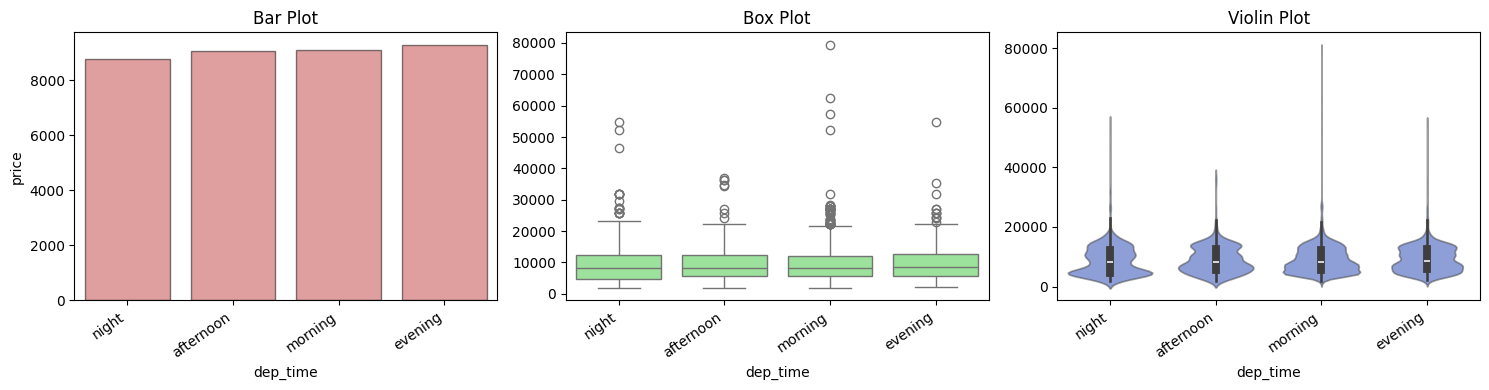

In [89]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### Conclusion:

- Majorty of the flights are in evening and their cost is high compared to others.

### 8.4 duration

In [90]:
train.duration

0       2295
1       2345
2        970
3        290
4       1215
        ... 
8363     170
8364     860
8365     300
8366     195
8367    1125
Name: duration, Length: 8368, dtype: int64

In [91]:
eda_helper_functions.num_summary(train, "duration")

0       2295
1       2345
2        970
3        290
4       1215
        ... 
8363     170
8364     860
8365     300
8366     195
8367    1125
Name: duration, Length: 8368, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 8,368 / 8,368 rows


,value
percentile,
0,75.0
5,90.0
10,145.0
25,170.0
50,510.0
75,925.0
90,1440.0
95,1600.0
99,1903.3


,value
mean,634.401291
trimmed mean (5%),600.674456
trimmed mean (10%),572.304361
median,510.000000


,value
var,252788.251520
std,502.780520
IQR,755.000000
mad,340.000000
coef_variance,0.792528


,value
skewness,0.894262
kurtosis,-0.053606


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 4.3851059159941304e-61
Test Statistic       : 0.8874794359058116
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 307.03021658972284
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [92]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    170.0
0.50    510.0
0.75    925.0
Name: duration, dtype: float64

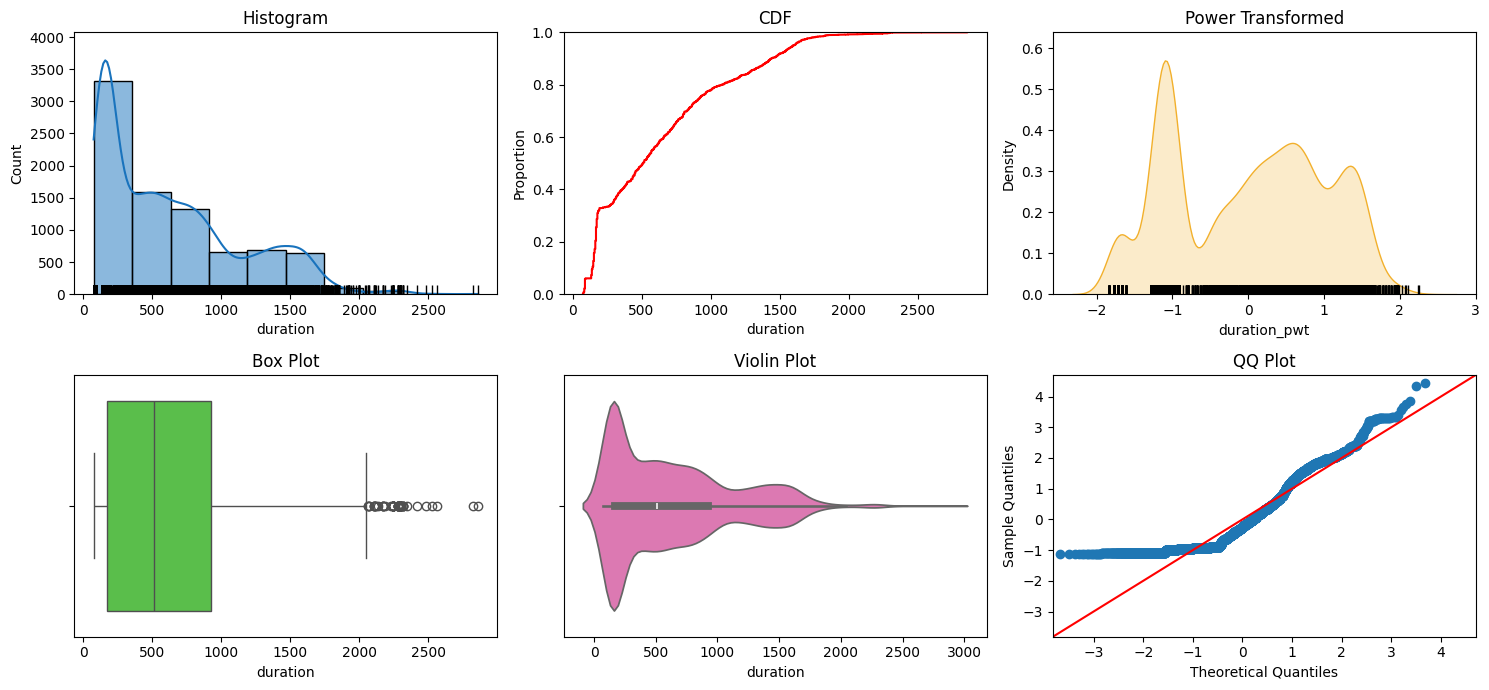

In [96]:
eda_helper_functions.num_univar_plots(train, "duration")

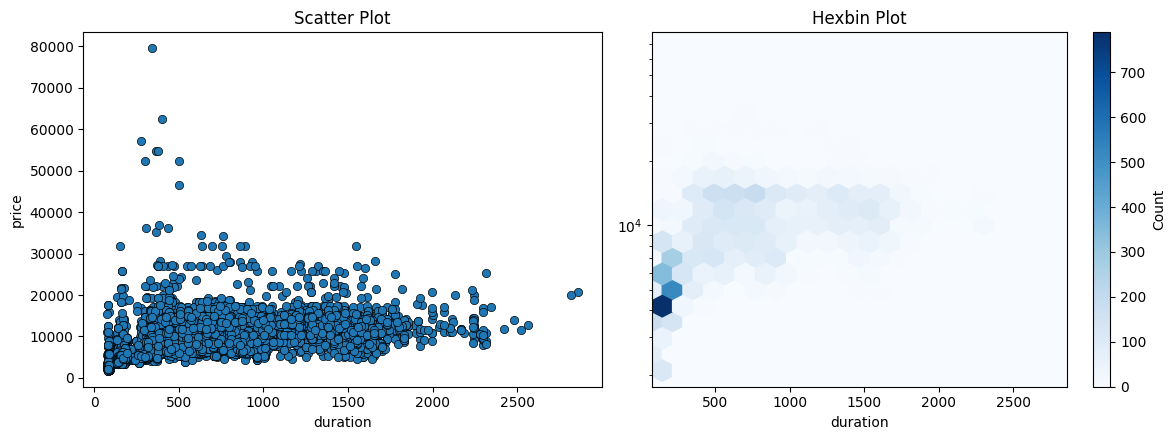

In [97]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [98]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.4990941310431376
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6912593222180128
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


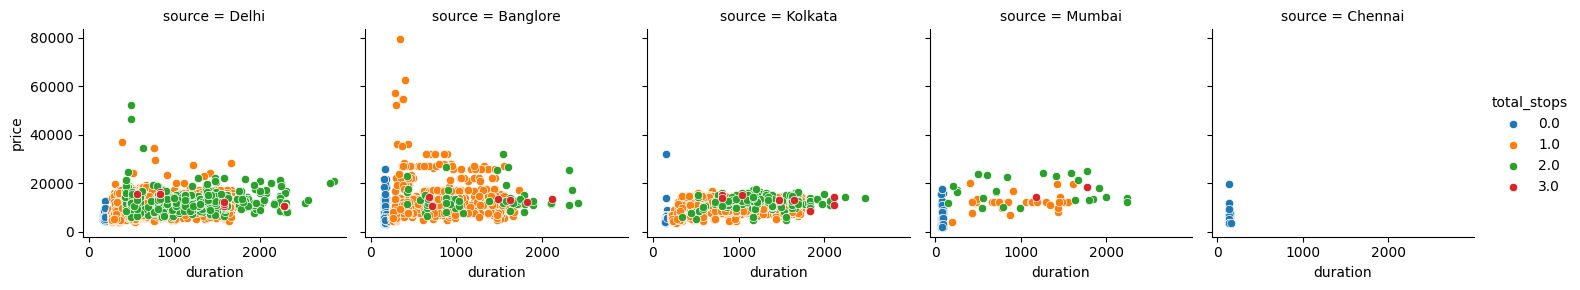

In [99]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

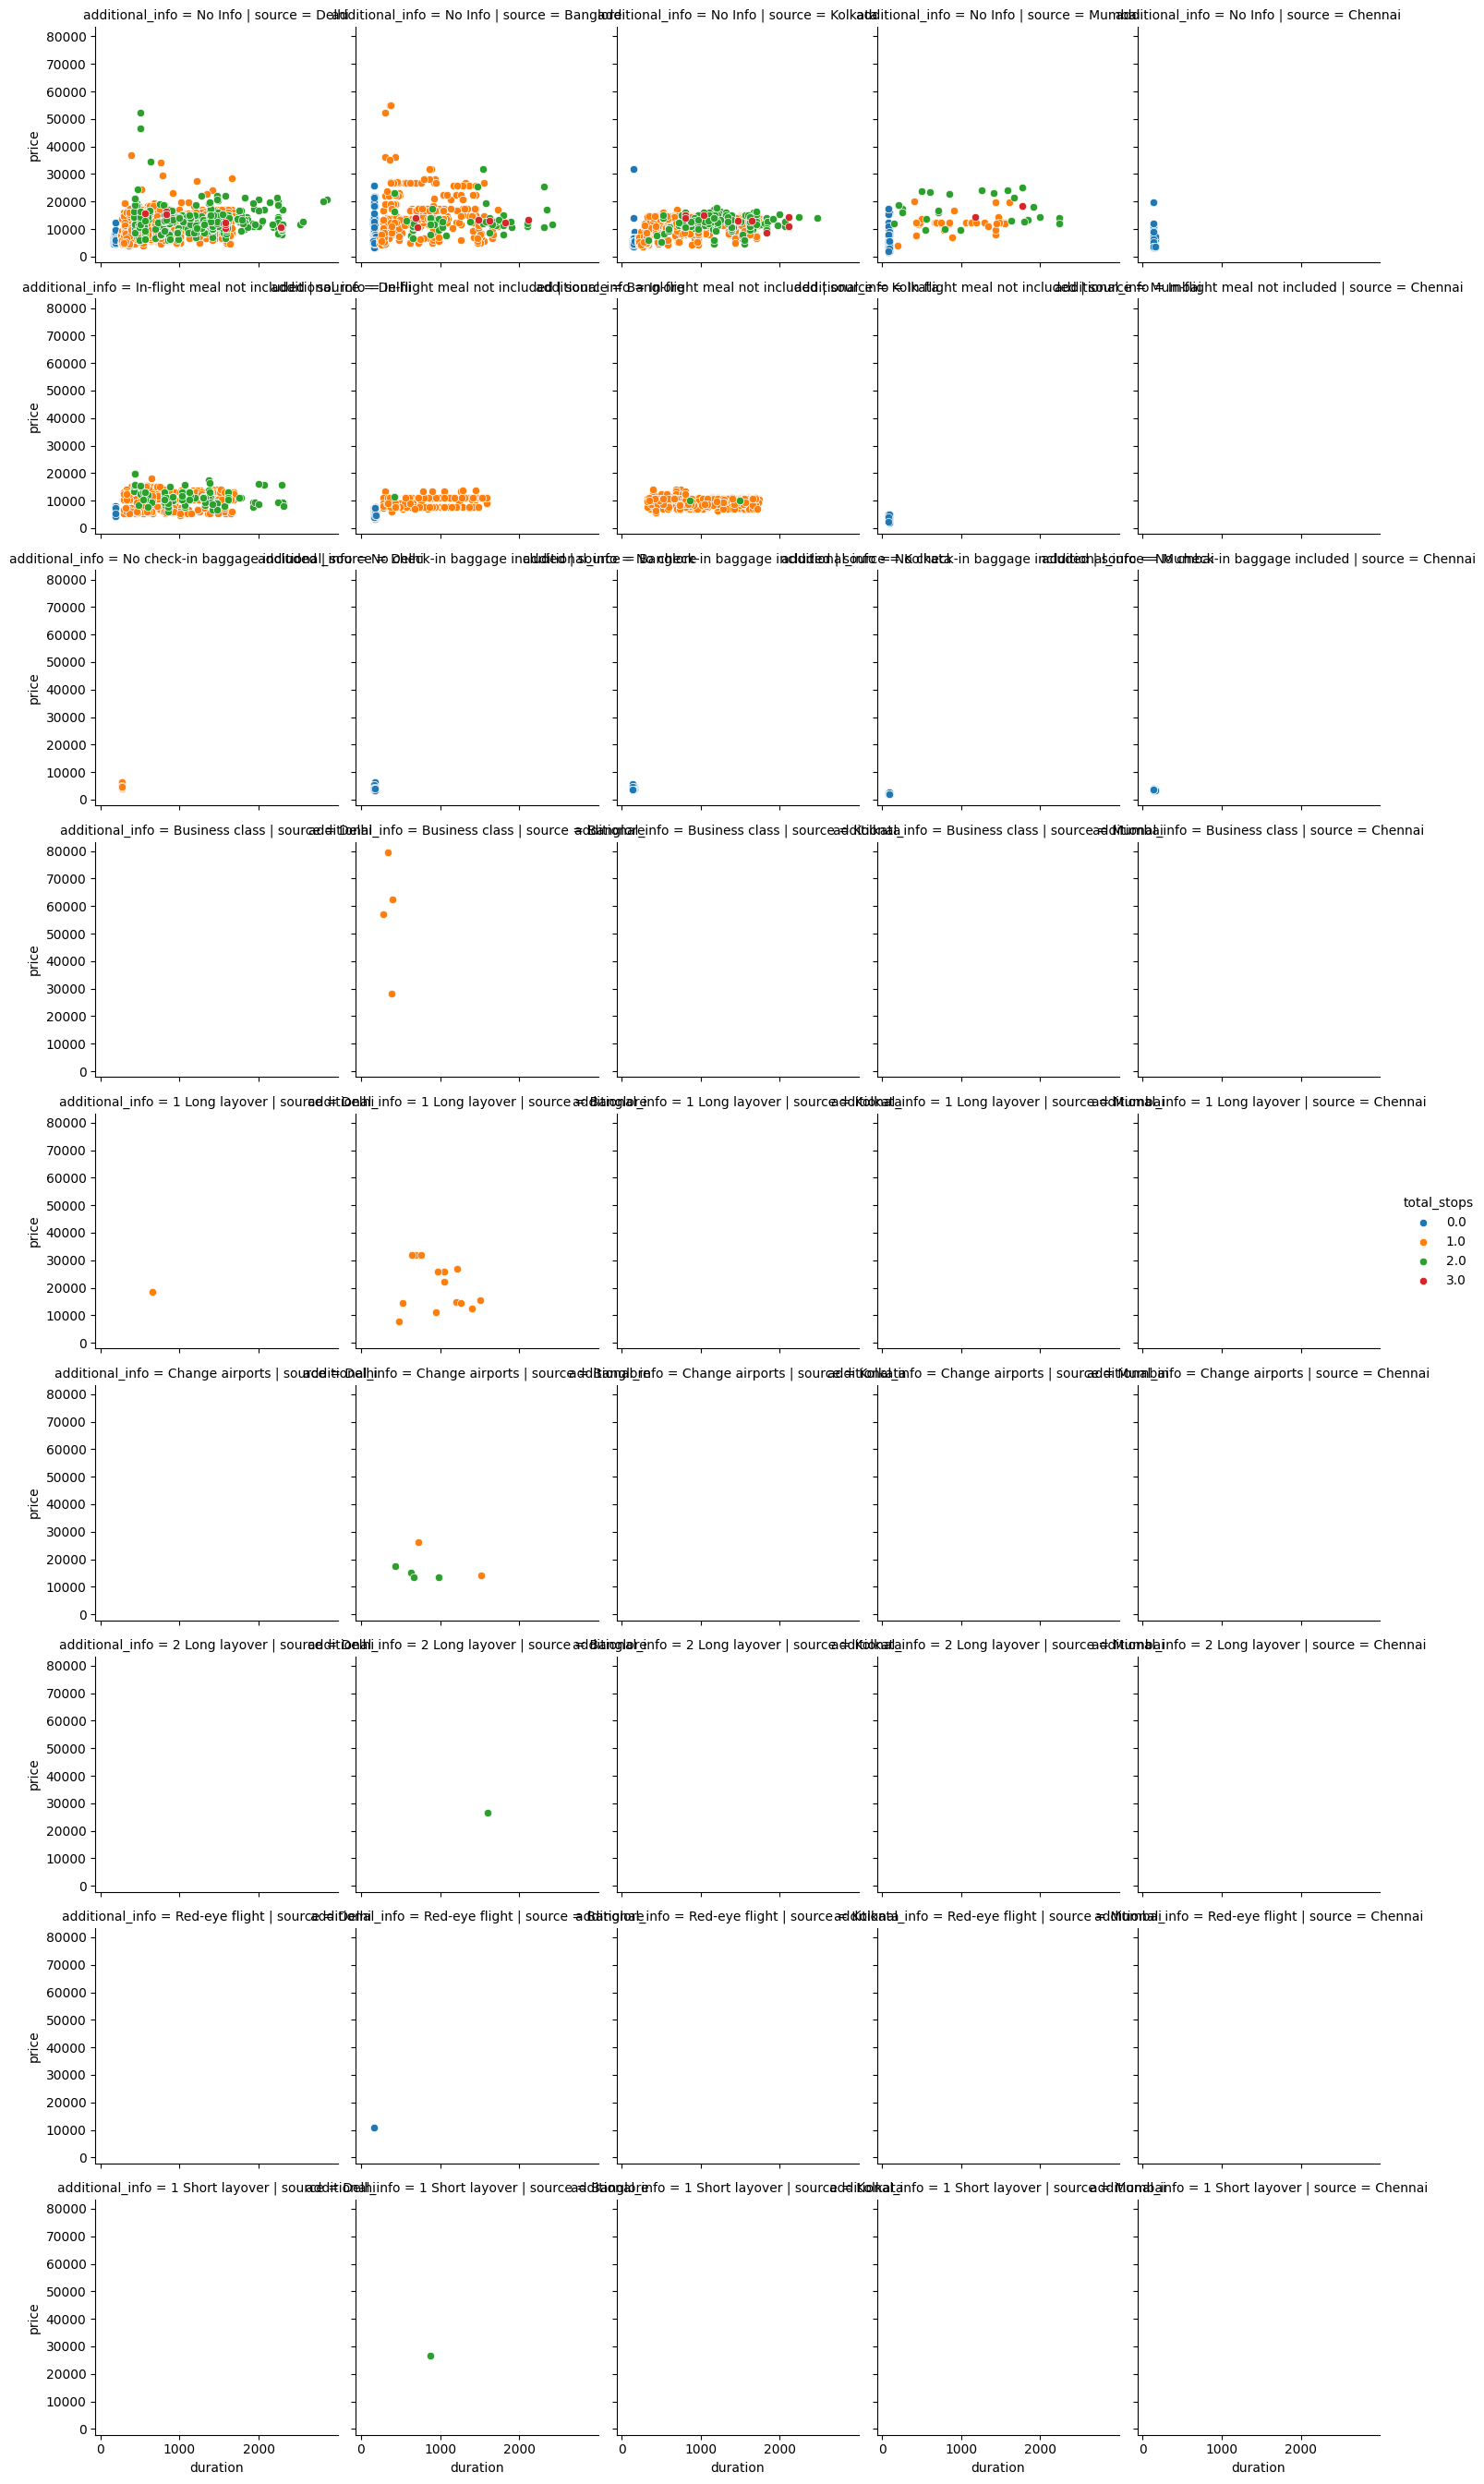

In [100]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [101]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -962.5
Upper Limit : 2057.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3489,Air India,2019-05-01,Kolkata,Banglore,2025-01-24 05:50:00,2025-01-24 16:15:00,2065,2.0,No Info,10991
8344,Air India,2019-05-15,Kolkata,Banglore,2025-01-24 05:50:00,2025-01-24 16:15:00,2065,2.0,No Info,12723
2143,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-24 17:55:00,2025-01-24 04:25:00,2070,2.0,No Info,17072
729,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-24 17:55:00,2025-01-24 04:25:00,2070,2.0,In-flight meal not included,15812
6542,Air India,2019-03-18,Banglore,New Delhi,2025-01-24 11:05:00,2025-01-24 22:10:00,2105,2.0,No Info,11161
...,...,...,...,...,...,...,...,...,...,...
5094,Air India,2019-03-24,Kolkata,Banglore,2025-01-24 05:55:00,2025-01-24 23:15:00,2480,2.0,No Info,13990
792,Jet Airways,2019-03-21,Delhi,Cochin,2025-01-24 10:20:00,2025-01-24 04:25:00,2525,2.0,No Info,11664
4578,Jet Airways,2019-03-21,Delhi,Cochin,2025-01-24 09:40:00,2025-01-24 04:25:00,2565,2.0,No Info,12819
7436,Jet Airways,2019-03-03,Delhi,Cochin,2025-01-24 05:25:00,2025-01-24 04:25:00,2820,2.0,No Info,20064


### 8.5 additional_info

In [102]:
eda_helper_functions.cat_summary(train, "additional_info")

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
8363                        No Info
8364    In-flight meal not included
8365                        No Info
8366                        No Info
8367    In-flight meal not included
Name: additional_info, Length: 8368, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 8,368 / 8,368 rows


,
count,8368
unique,9
top,No Info
freq,6551


,count,percentage
category,,
No Info,6551,0.782863
In-flight meal not included,1541,0.184154
No check-in baggage included,248,0.029637
1 Long layover,15,0.001793
Change airports,6,0.000717
Business class,4,0.000478
2 Long layover,1,0.000120
Red-eye flight,1,0.000120
1 Short layover,1,0.000120


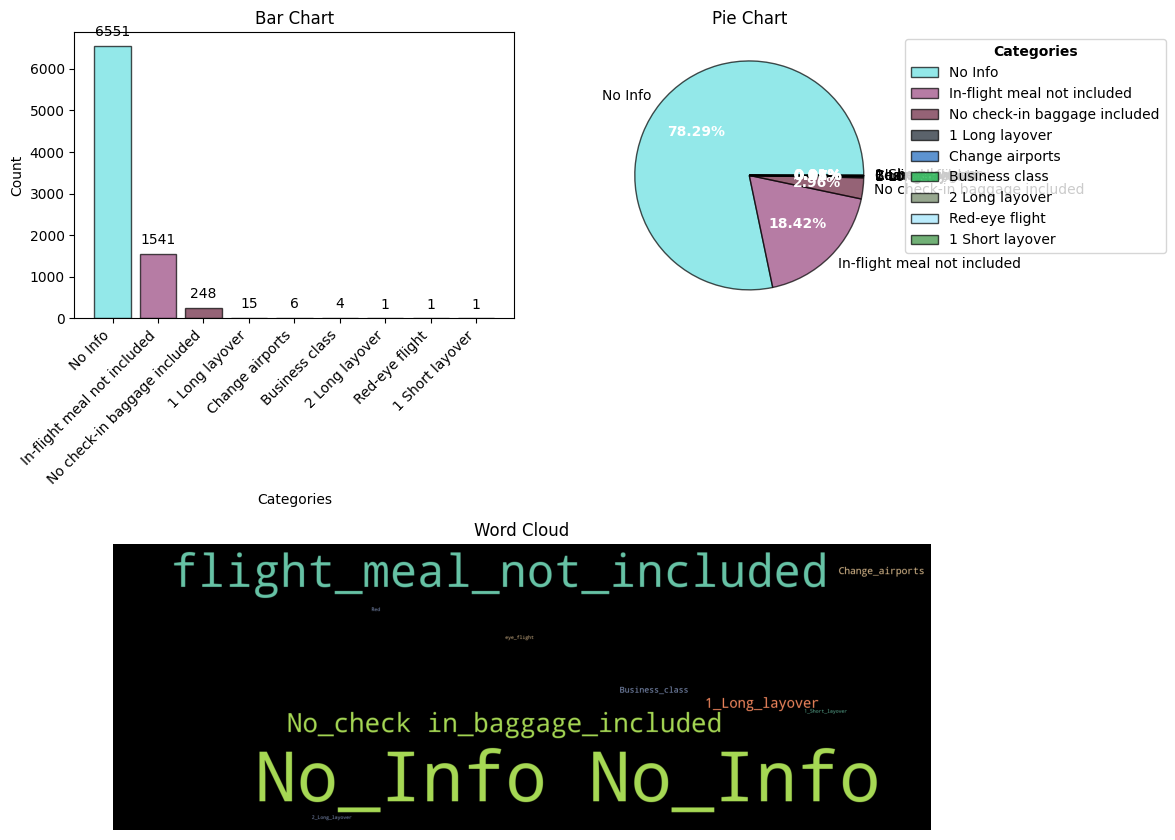

In [103]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

### Conclusion:

- For most of the flights no Additional information is available.

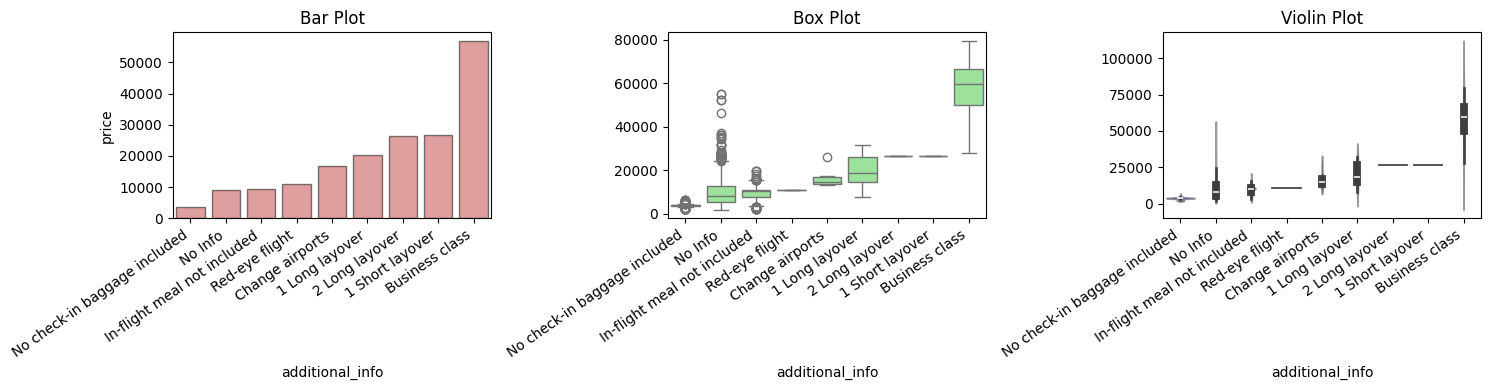

In [105]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

### Conclusion:

- For business class Price is highest.

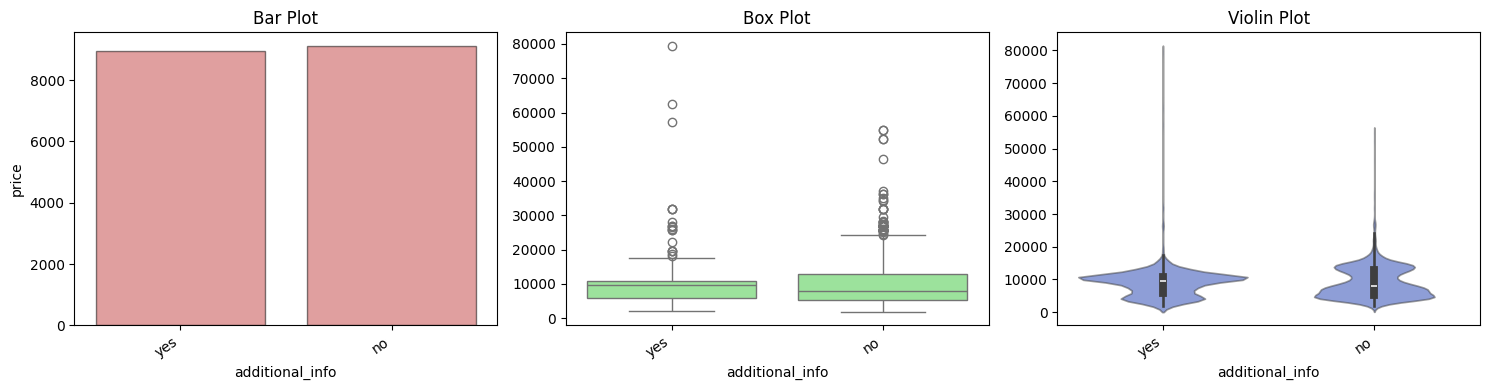

In [106]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- `additional_info` has severely rare categories
- Converted it into a binary feature for further analysis

## 9. Automated EDA

In [107]:
# from ydata_profiling import ProfileReport

In [108]:
# report = ProfileReport(train)

In [109]:
# report.to_file(output_file="output.html")